## Visualization

In [74]:
import branca.colormap as cm
import folium
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns

from branca import colormap
from geopy.geocoders import Nominatim
from matplotlib.colors import ListedColormap
from shapely.ops import unary_union
from shapely import wkt
from tqdm import tqdm

plt.style.use("dark_background")
matplotlib.rcParams.update({'font.size': 16})

### Coloring Methods

In [75]:
def alpha_blend_cmap(cmap: str, alpha: float):
    cls = plt.get_cmap(cmap)(np.linspace(0, 1, 256))
    cls = (1-alpha) + alpha*cls
    return ListedColormap(cls)


def color_palette(cmap_label: str, cmap_width: int, range_width: int, reversed: bool):
    colors = []
    cmap = plt.get_cmap(cmap_label, cmap_width)

    color_range = range(cmap_width - 1, cmap_width -
                        range_width - 1, -1) if reversed else range(range_width)
    for i in color_range:
        colors.append(cmap(i))
    return colors


def get_plot_kws(scatter_kws: str, line_kws: str):
    return {'line_kws': {'color': line_kws, "lw": 5}, 'scatter_kws': {'color': scatter_kws, "s": 60}}

### Methods

In [76]:
def get_polygons(geolocator: Nominatim, bounding: str, geopy_index: int):
    polygons = []
    substracts = []
    for location in bounding.replace("[", "").replace("]", "").split(","):
        if location.startswith("-"):
            geocodes = geolocator.geocode(location[1:] + ', QC', geometry='wkt', exactly_one=False)
            for geocode in geocodes:
                substracts.append(wkt.loads(geocode.raw['geotext']))
        else:
            geocode = geolocator.geocode(location + ', QC', geometry='wkt', exactly_one=False)[geopy_index]
            polygons.append(wkt.loads(geocode.raw['geotext']))

    return polygons, substracts  

In [77]:
def get_geojson(geolocator: Nominatim, bounding: str, geopy_index: int):
    polygons, substracts = get_polygons(geolocator, bounding, geopy_index)
    return gpd.GeoSeries(unary_union(polygons).difference(unary_union(substracts))).simplify(tolerance=0.001).to_json()

In [78]:
def add_geometry(geomap: folium.Map, geolocator: Nominatim, bounding: str, popup: str, color: str, geopy_index: int):
    geo_json = get_geojson(geolocator, bounding, geopy_index)
    geo_j = folium.GeoJson(data=geo_json, style_function=lambda x: {'weight': 2, 'color': 'white', 'fillOpacity': 0.3, 'fillColor': color})
    folium.Popup(popup).add_to(geo_j)
    geo_j.add_to(geomap)

In [79]:
def reorder_column(df: pd.DataFrame, column: str):
    first_cols = [column]
    last_cols = [col for col in df.columns if col not in first_cols]
    return df[first_cols+last_cols]

In [80]:
def group_column(df: pd.DataFrame, column: str):
    value_counts = df[column].value_counts()
    df = df.groupby(column).mean().astype(int).reset_index()
    df.insert(0, 'Nb of listings', '')
    df['Nb of listings'] = df[column].map(value_counts).astype(int)
    return reorder_column(df, column)

In [81]:
def first_digits(number):
    return str(number)[:3]

def add_price_ranges(df: pd.DataFrame, prices: list):
    conditions = [df['Price'] < prices[0]]
    labels = ["0-" + first_digits(prices[0]) + "k"]

    for i in range(len(prices) - 1):
        conditions.append((df['Price'] >= prices[i]) & (df['Price'] < prices[i+1]))
        labels.append(first_digits(prices[i]) + "k-" + first_digits(prices[i+1]) + "k")
    conditions.append(df['Price'] >= prices[-1])
    labels.append(">" + first_digits(prices[-1]) + "k")
    df['Price Range'] = np.select(conditions, labels, default=0)
    return df, labels

In [82]:
def add_value_ranges(df: pd.DataFrame, column: str, values: list, unit: str):
    conditions = [df[column] < values[0]]
    labels = ["0-" + str(values[0]) + " " + unit]

    for i in range(len(values) - 1):
        conditions.append((df[column] >= values[i]) & (df[column] < values[i+1]))
        labels.append(str(values[i]) + "-" + str(values[i+1]) + " "  + unit)
    conditions.append(df[column] >= values[-1])
    labels.append(">" + str(values[-1]) + " " + unit)
    df[column + ' Range'] = np.select(conditions, labels, default=0)
    return df, labels

### Read Processed Data

In [83]:
listings_df = pd.read_csv('../data/processed/processed-listings.csv')
listings_df.sample(5)

,Subtype,Style,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Date,Listing Year,Year of Construction,Age,Location,Price
6113,2 Storey,2 storey,2260,12324,5,1,2,2020-12-01,2020,1941,79,L'Islet & Montmagny,117000
20283,Bungalow,Unknown,1221,10066,4,2,1,2019-05-01,2019,1976,43,Lévis,258000
57155,Bungalow,Detached,1200,5000,3,2,1,2012-06-01,2012,1994,18,Thérèse-De Blainville,232000
92031,Condominium,Divided Co-Ownership,980,9291,2,1,1,2011-01-01,2011,1992,19,Rivière-des-Prairies-Pointe-aux-Trembles & Mon...,148500
17639,2 Storey,Heritage,2044,49300,3,2,2,2019-07-01,2019,1870,149,La Vallée-du-Richelieu,125000


### Correlation Map

In [84]:
def plot_corr_map(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.triu(np.ones_like(corr, dtype=bool))

    # Set up the matplotlib figure
    _, _ = plt.subplots(figsize=(16, 16))

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, vmax=.3, cmap=color_palette("rocket", 175, 100, False), center=0,
                square=True, linewidths=0, cbar_kws={"shrink": .5}, annot=True)

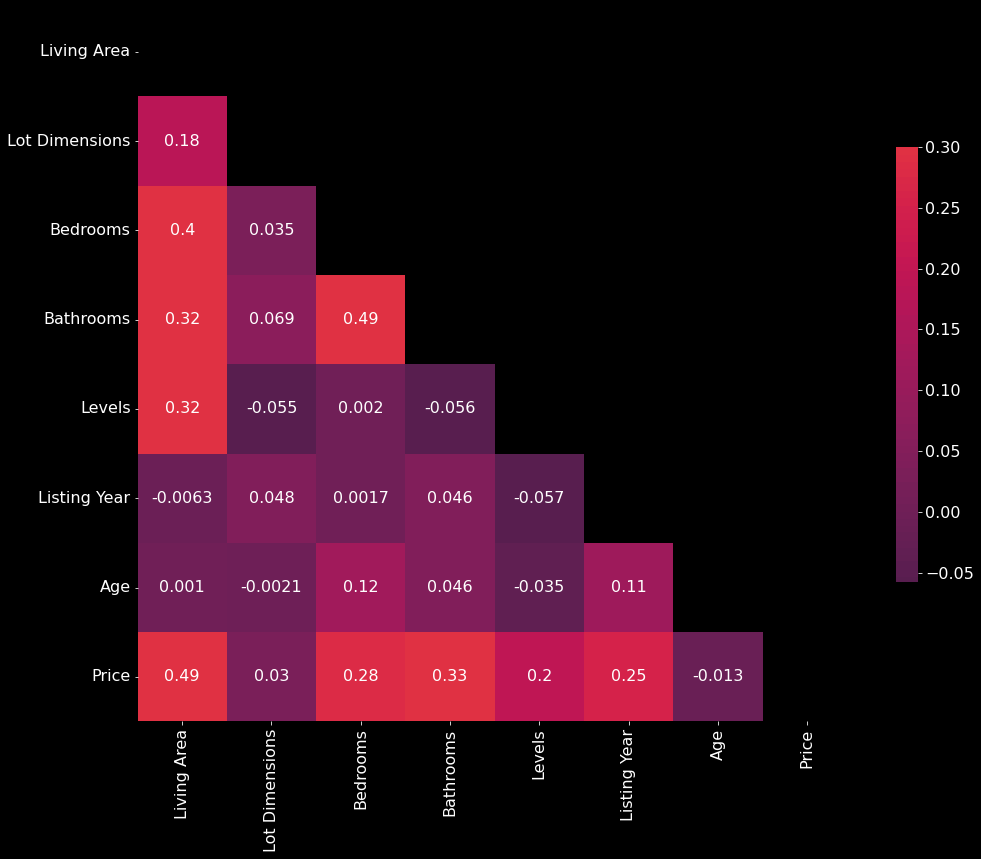

In [85]:
plot_corr_map(listings_df.drop(columns=["Year of Construction"]))
plt.savefig('./figures/visualization/corr-map.png', transparent=True, bbox_inches='tight')

### Subtype

In [86]:
subtype_df = group_column(listings_df, 'Subtype')
subtype_df = subtype_df.sort_values(by=['Price'], ascending=True)
subtype_df.head(9)

,Subtype,Nb of listings,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Year,Year of Construction,Age,Price
5,Mobile home,462,941,7411,2,1,1,2016,1982,33,120289
6,Semi-detached,11511,1167,4611,3,1,1,2015,1997,17,243906
3,Condominium,21715,1049,8714,2,1,1,2015,1996,19,245314
0,1 1/2 Storey,3022,1449,13975,3,1,1,2016,1973,43,248906
4,Country Home,467,1516,18032,3,1,1,2015,1978,37,253445
2,Bungalow,30224,1155,10816,3,1,1,2015,1986,29,262254
8,Townhouse,4736,1280,3590,2,1,2,2015,1996,18,283248
7,Split Level,3089,1374,9151,3,1,1,2015,1986,29,309426
1,2 Storey,19413,1747,10857,3,1,1,2015,1989,25,352658


C:\Users\simka\AppData\Local\Temp\ipykernel_23896\2095101027.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "50k", "100k", "150k", "200k", "250k", "300k", "350k"])


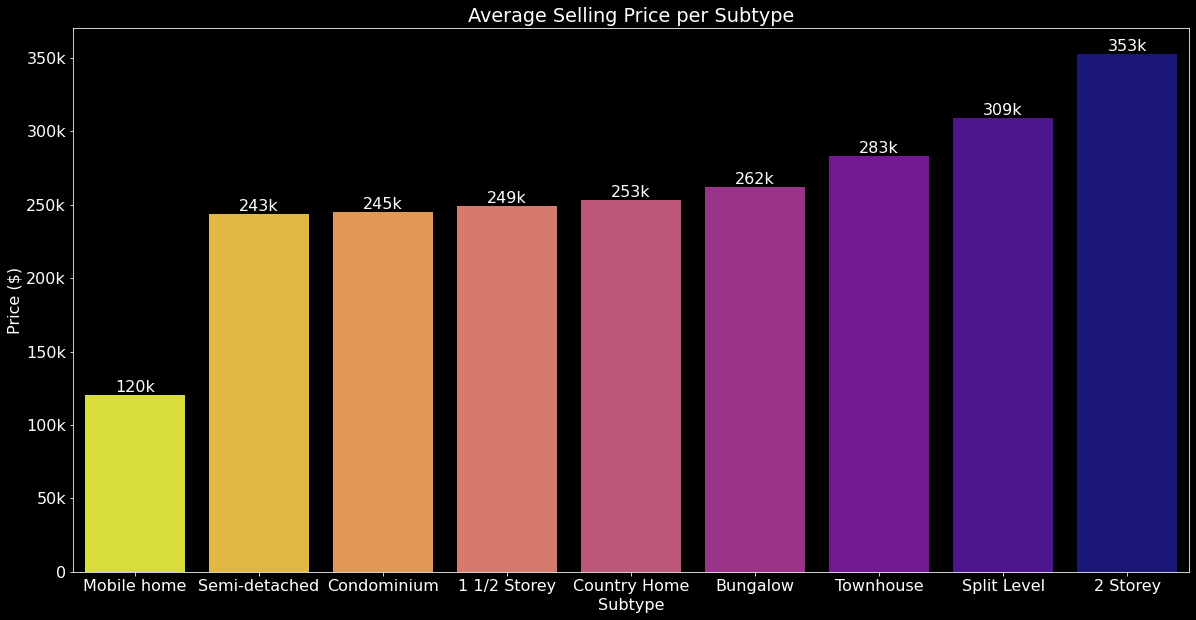

In [87]:
fig = plt.figure(figsize=[20, 10])
ax = sns.barplot(x="Subtype", y="Price", data=subtype_df, palette=color_palette("plasma", 9, 9, True))

ax.set_title("Average Selling Price per Subtype")
ax.set_ylabel("Price ($)")
ax.set_yticklabels(["0", "50k", "100k", "150k", "200k", "250k", "300k", "350k"])
ax.bar_label(ax.containers[0], labels=["120k", "243k", "245k", "249k", "253k", "262k", "283k", "309k", "353k"])
fig.add_axes(ax)

plt.savefig('./figures/visualization/subtype-barplot.png', transparent=True, bbox_inches='tight')

### Living Area

In [88]:
df, _ = add_value_ranges(listings_df, "Living Area", [1000, 1250, 1500, 2000], "sq.ft")
la_df = group_column(df, 'Living Area Range')
la_df = la_df.sort_values(by=['Price'], ascending=True)
la_df.head()

,Living Area Range,Nb of listings,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Year,Year of Construction,Age,Price
0,0-1000 sq.ft,24334,846,8170,2,1,1,2015,1990,25,217751
1,1000-1250 sq.ft,31603,1116,8702,2,1,1,2015,1990,25,250442
2,1250-1500 sq.ft,17070,1357,8972,3,1,1,2015,1992,22,291147
3,1500-2000 sq.ft,14568,1690,10833,3,1,1,2015,1990,24,342974
4,>2000 sq.ft,7064,2440,13385,3,1,1,2015,1988,26,417710


C:\Users\simka\AppData\Local\Temp\ipykernel_23896\1948514643.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "50k", "100k", "150k", "200k", "250k", "300k", "350k", "400k"])


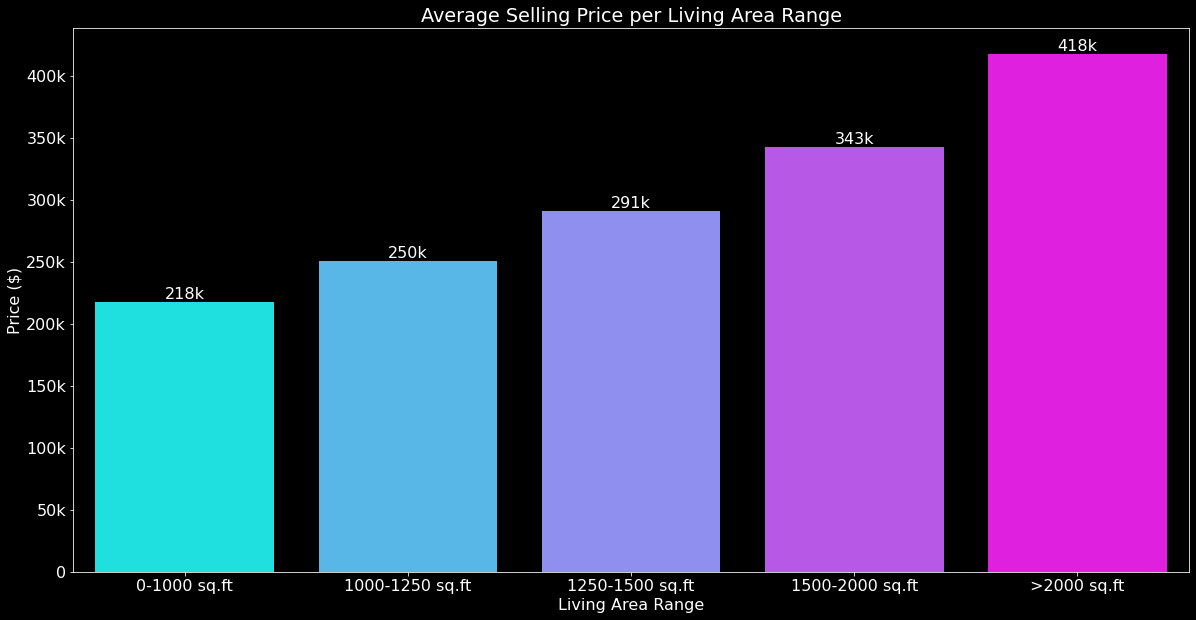

In [89]:
fig = plt.figure(figsize=[20, 10])
ax = sns.barplot(x="Living Area Range", y="Price", data=la_df, palette=color_palette("cool", 5, 5, False))

ax.set_title("Average Selling Price per Living Area Range")
ax.set_ylabel("Price ($)")
ax.set_yticklabels(["0", "50k", "100k", "150k", "200k", "250k", "300k", "350k", "400k"])
ax.bar_label(ax.containers[0], labels=["218k", "250k", "291k", "343k", "418k"])
fig.add_axes(ax)

plt.savefig('./figures/visualization/livingarea-barplot.png', transparent=True, bbox_inches='tight')

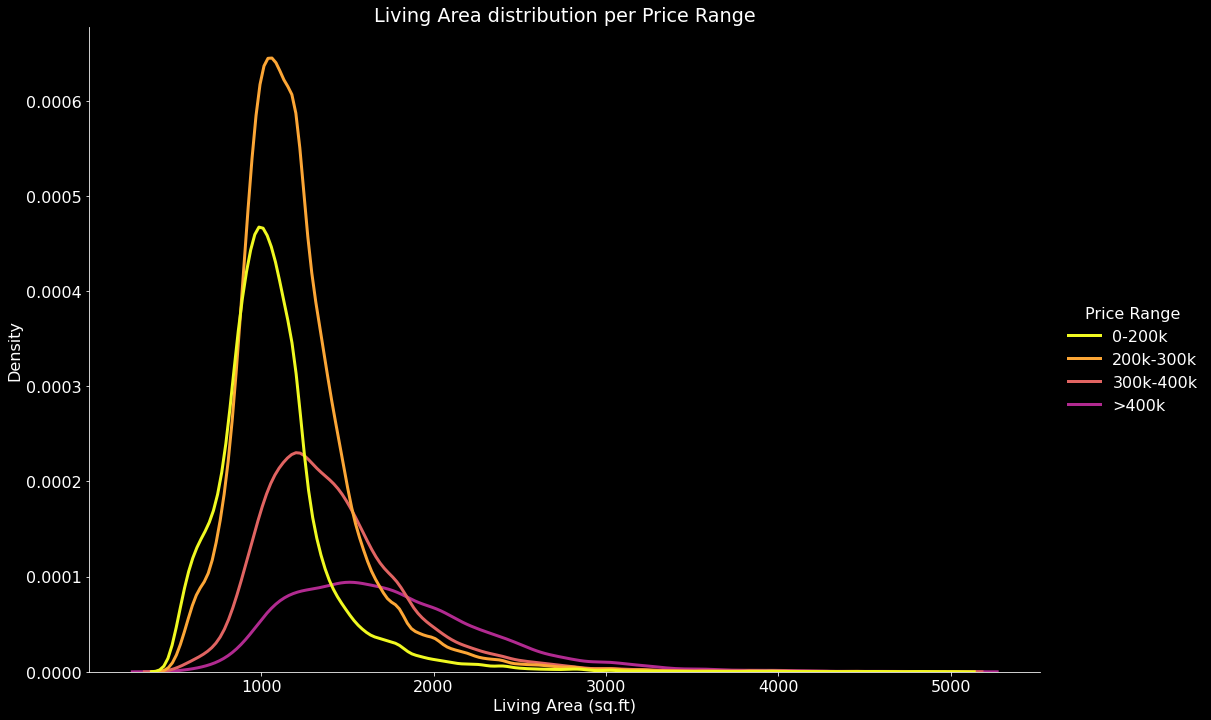

In [90]:
ranges = [200000, 300000, 400000]
df, labels = add_price_ranges(listings_df, ranges)

ax = sns.displot(df, x='Living Area', hue='Price Range', hue_order=labels, kind="kde", common_norm=True,
            height=10, aspect=1.5, linewidth=3, palette=color_palette("plasma", 6, len(ranges) + 1, True))
ax.set(title="Living Area distribution per Price Range", xlabel="Living Area (sq.ft)")

plt.savefig('./figures/visualization/livingarea-displot.png', transparent=True, bbox_inches='tight')

c:\Users\simka\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\axisgrid.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


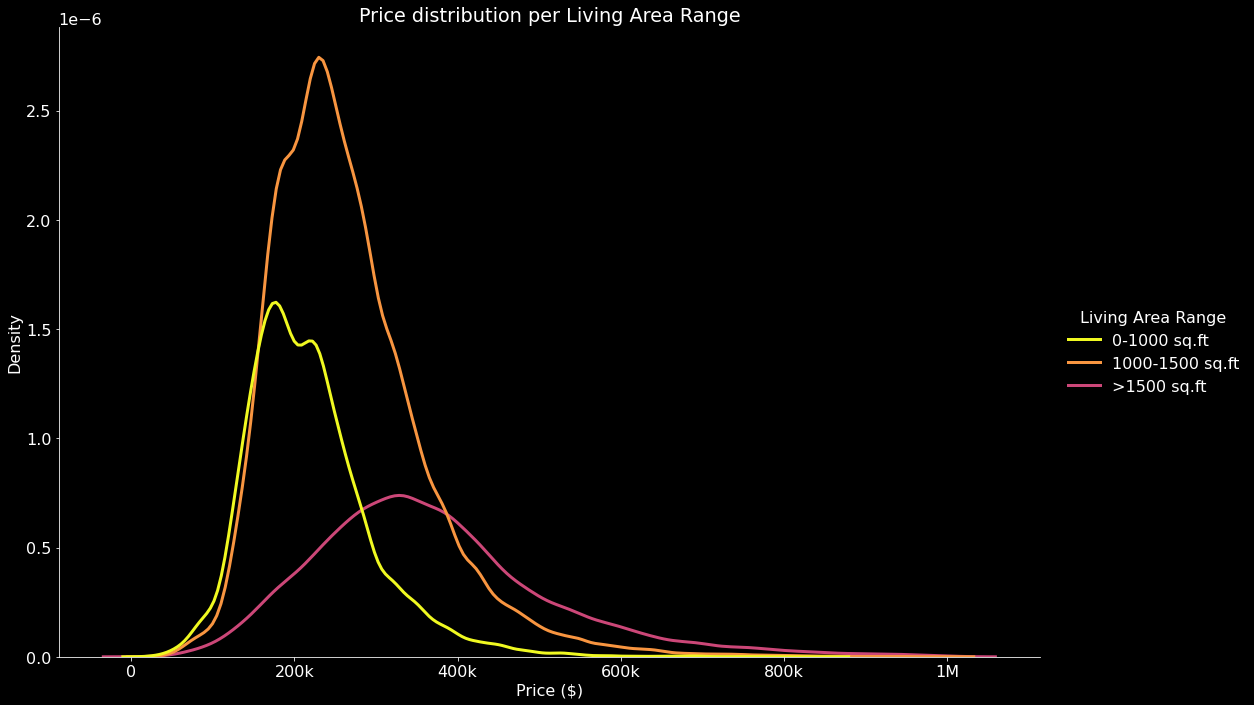

In [92]:
ranges = [1000, 1500]
df, labels = add_value_ranges(listings_df, "Living Area", ranges, "sq.ft")

ax = sns.displot(df, x='Price', hue='Living Area Range', hue_order=labels, kind="kde", common_norm=True,
            height=10, aspect=1.5, linewidth=3, palette=color_palette("plasma", 5, len(ranges) + 1, True))
ax.set(title="Price distribution per Living Area Range", xlabel="Price ($)", xticklabels=["0", "0", "200k", "400k", "600k", "800k", "1M"])

plt.savefig('./figures/visualization/livingarea-pricedisplot.png', transparent=True, bbox_inches='tight')

C:\Users\simka\AppData\Local\Temp\ipykernel_23896\817506144.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "200k", "400k", "600k", "800k", "1M"])


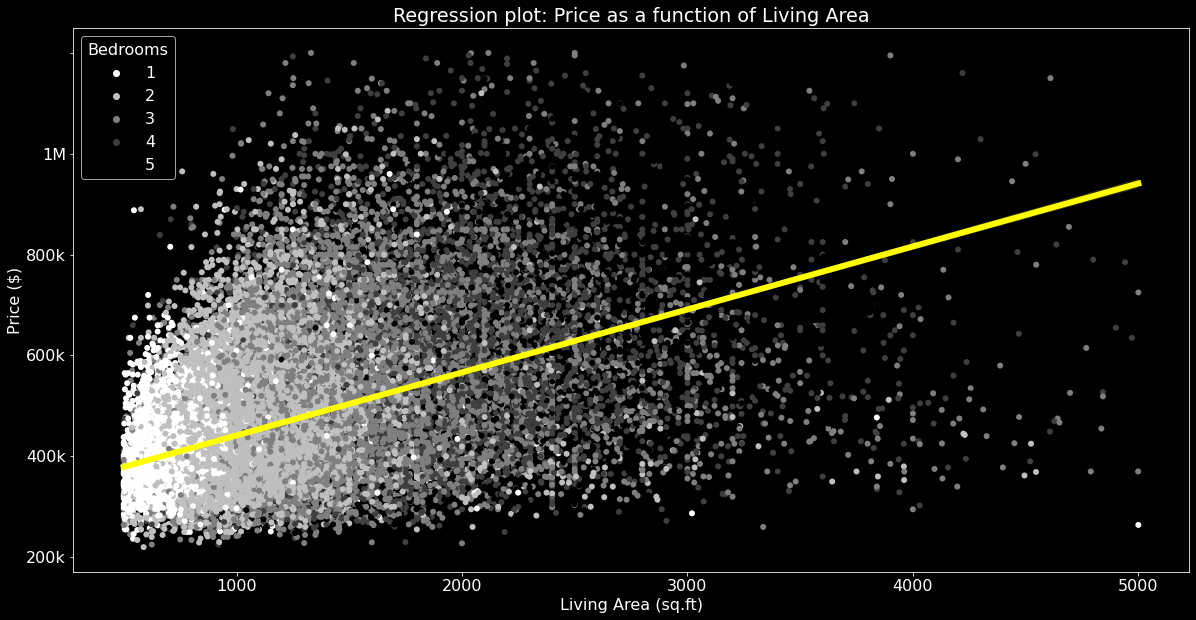

In [93]:
fig, ax = plt.subplots(figsize=(20, 10))
p1 = sns.scatterplot(data=listings_df, x="Living Area", y="Price", hue="Bedrooms", palette="gist_yarg", linewidth=0, ax=ax)
p2 = sns.regplot(data=listings_df, x='Living Area', y='Price', color='yellow', line_kws={'linewidth':6}, ax=ax, scatter=False)

ax.set_title("Regression plot: Price as a function of Living Area")
ax.set_ylabel("Price ($)")
ax.set_xlabel("Living Area (sq.ft)")
ax.set_yticklabels(["0", "200k", "400k", "600k", "800k", "1M"])

plt.savefig('./figures/visualization/livingarea-regplot.png', transparent=True, bbox_inches='tight')

### Lot Dimensions

C:\Users\simka\AppData\Local\Temp\ipykernel_23896\2728539025.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "200k", "400k", "600k", "800k", "1M"])


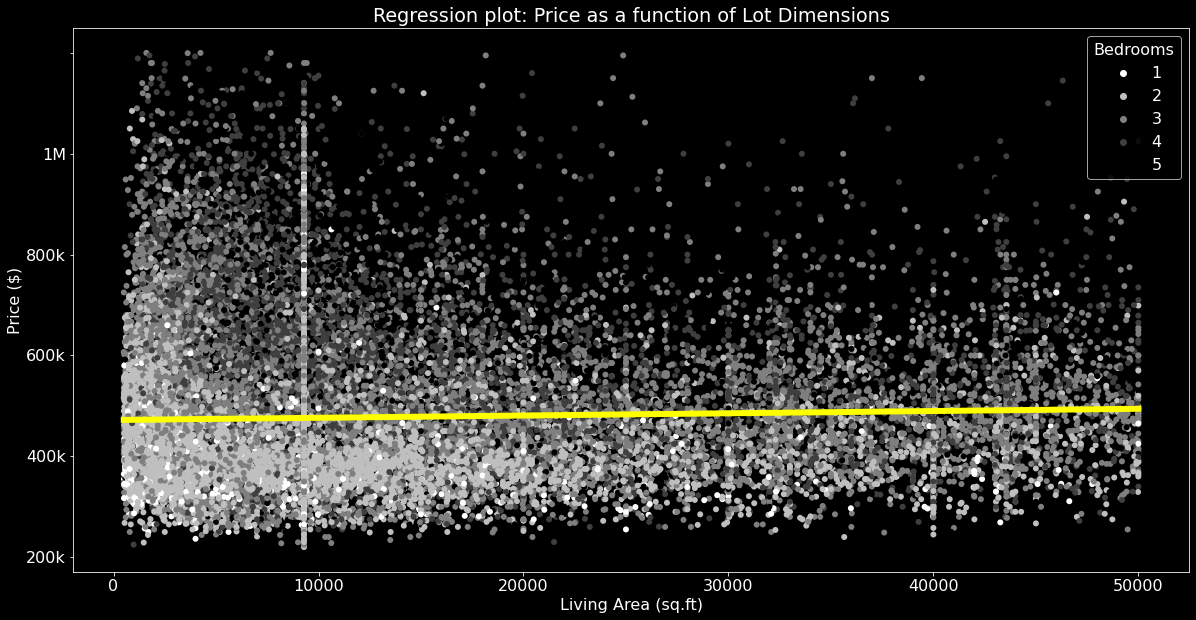

In [94]:
fig, ax = plt.subplots(figsize=(20, 10))
p1 = sns.scatterplot(data=listings_df, x="Lot Dimensions", y="Price", hue="Bedrooms", palette="gist_yarg", linewidth=0, ax=ax)
p2 = sns.regplot(data=listings_df, x='Lot Dimensions', y='Price', color='yellow', line_kws={'linewidth':6}, ax=ax, scatter=False)

ax.set_title("Regression plot: Price as a function of Lot Dimensions")
ax.set_ylabel("Price ($)")
ax.set_xlabel("Living Area (sq.ft)")
ax.set_yticklabels(["0", "200k", "400k", "600k", "800k", "1M"])

plt.savefig('./figures/visualization/lotdimensions-regplot.png', transparent=True, bbox_inches='tight')

### Bedrooms

In [95]:
bedrooms_df = group_column(listings_df, 'Bedrooms')
bedrooms_df = bedrooms_df.sort_values(by=['Bedrooms'], ascending=True)
bedrooms_df

,Bedrooms,Nb of listings,Living Area,Lot Dimensions,Bathrooms,Levels,Listing Year,Year of Construction,Age,Price
0,1,3325,752,9349,1,1,2016,1993,23,208884
1,2,24111,1081,9167,1,1,2015,1995,20,235636
2,3,37030,1291,9001,1,1,2015,1990,25,277520
3,4,23127,1415,9475,1,1,2015,1988,26,306438
4,5,7046,1671,10617,1,1,2015,1985,30,339342


C:\Users\simka\AppData\Local\Temp\ipykernel_23896\1374448592.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "50k", "100k", "150k", "200k", "250k", "300k", "350k"])


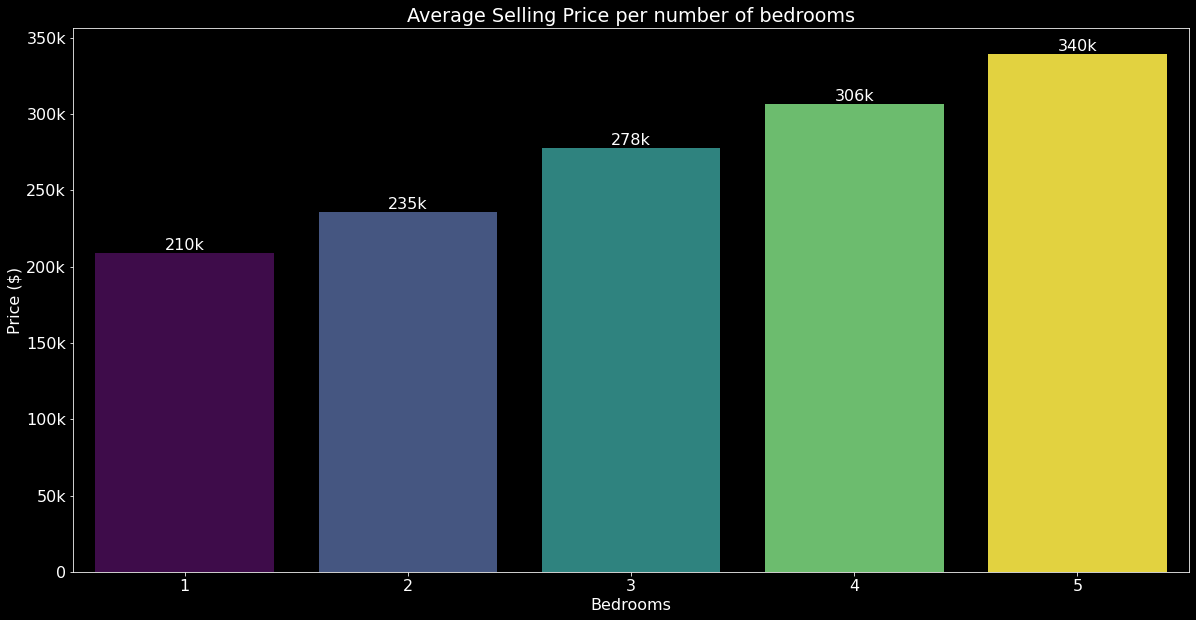

In [96]:
fig = plt.figure(figsize=[20, 10])
ax = sns.barplot(x="Bedrooms", y="Price", data=bedrooms_df, palette=color_palette("viridis", 5, 5, False))

ax.set_title("Average Selling Price per number of bedrooms")
ax.set_ylabel("Price ($)")
ax.set_yticklabels(["0", "50k", "100k", "150k", "200k", "250k", "300k", "350k"])
ax.bar_label(ax.containers[0], labels=["210k", "235k", "278k", "306k", "340k"])
fig.add_axes(ax)

plt.savefig('./figures/visualization/bedrooms-barplot.png', transparent=True, bbox_inches='tight')

C:\Users\simka\AppData\Local\Temp\ipykernel_23896\2192438730.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "200k", "400k", "600k", "800k", "1M"])


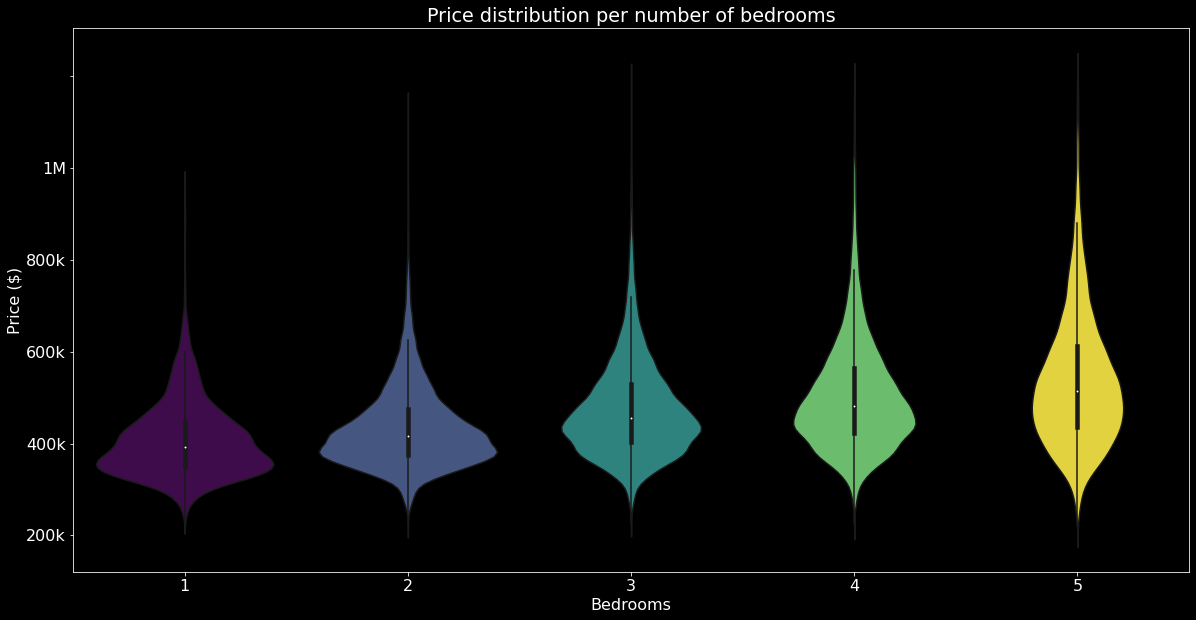

In [97]:
fig = plt.figure(figsize=[20, 10])
ax = sns.violinplot(data=listings_df, x="Bedrooms", y="Price", palette=color_palette("viridis", 5, 5, False))

ax.set_title("Price distribution per number of bedrooms")
ax.set_ylabel("Price ($)")
ax.set_yticklabels(["0", "200k", "400k", "600k", "800k", "1M"])
fig.add_axes(ax)

plt.savefig('./figures/visualization/bedrooms-violinplot.png', transparent=True, bbox_inches='tight')

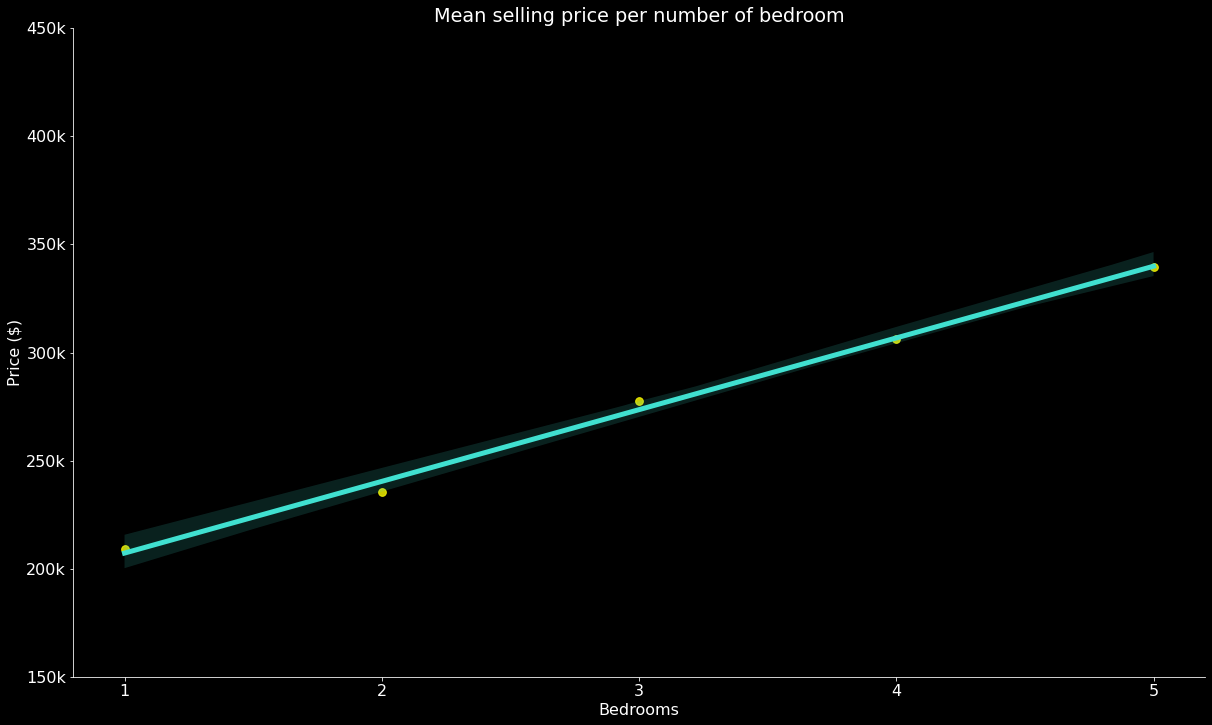

In [98]:
ax = sns.pairplot(data=bedrooms_df, x_vars='Bedrooms', y_vars='Price',
                  kind="reg", height=10, aspect=1.75, plot_kws=get_plot_kws('yellow', 'turquoise'))
ax.set(title="Mean selling price per number of bedroom", xticks=bedrooms_df["Bedrooms"].unique(
), yticks=range(150000, 500000, 50000), ylabel="Price ($)", yticklabels=["150k", "200k", "250k", "300k", "350k", "400k", "450k"])

plt.savefig('./figures/visualization/bedrooms-regplot.png', transparent=True, bbox_inches='tight')

### Bathrooms

In [99]:
bathrooms_df = group_column(listings_df, 'Bathrooms')
bathrooms_df = bathrooms_df.sort_values(by=['Bathrooms'], ascending=True)
bathrooms_df

,Bathrooms,Nb of listings,Living Area,Lot Dimensions,Bedrooms,Levels,Listing Year,Year of Construction,Age,Price
0,1,54011,1176,8900,2,1,2015,1991,23,247185
1,2,38236,1367,9668,3,1,2015,1989,26,306328
2,3,2243,2089,11992,4,1,2015,1989,25,444828
3,4,149,2552,14078,4,1,2015,1981,34,465223


C:\Users\simka\AppData\Local\Temp\ipykernel_23896\4046084722.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "100k", "200k", "300k", "400k"])


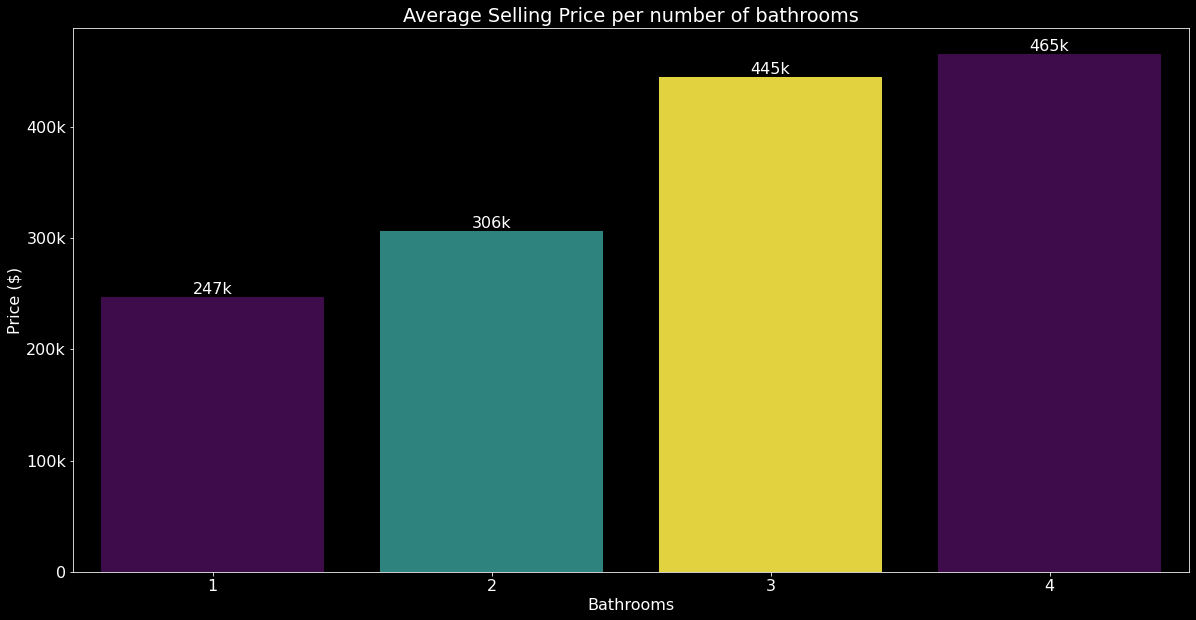

In [100]:
fig = plt.figure(figsize=[20, 10])
ax = sns.barplot(x="Bathrooms", y="Price", data=bathrooms_df, palette=color_palette("viridis", 3, 3, False))

ax.set_title("Average Selling Price per number of bathrooms")
ax.set_ylabel("Price ($)")
ax.set_yticklabels(["0", "100k", "200k", "300k", "400k"])
ax.bar_label(ax.containers[0], labels=["247k", "306k", "445k", "465k"])
fig.add_axes(ax)

plt.savefig('./figures/visualization/bathrooms-barplot.png', transparent=True, bbox_inches='tight')

### Levels

In [101]:
levels_df = group_column(listings_df, 'Levels')
levels_df = levels_df.sort_values(by=['Levels'], ascending=True)
levels_df

,Levels,Nb of listings,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Listing Year,Year of Construction,Age,Price
0,1,50804,1097,9689,2,1,2015,1990,25,249943
1,2,38351,1533,8893,3,1,2015,1990,24,310908
2,3,5484,1158,8401,2,1,2014,1993,21,275124


C:\Users\simka\AppData\Local\Temp\ipykernel_23896\2609203518.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "50k", "100k", "150k", "200k", "250k", "300k"])


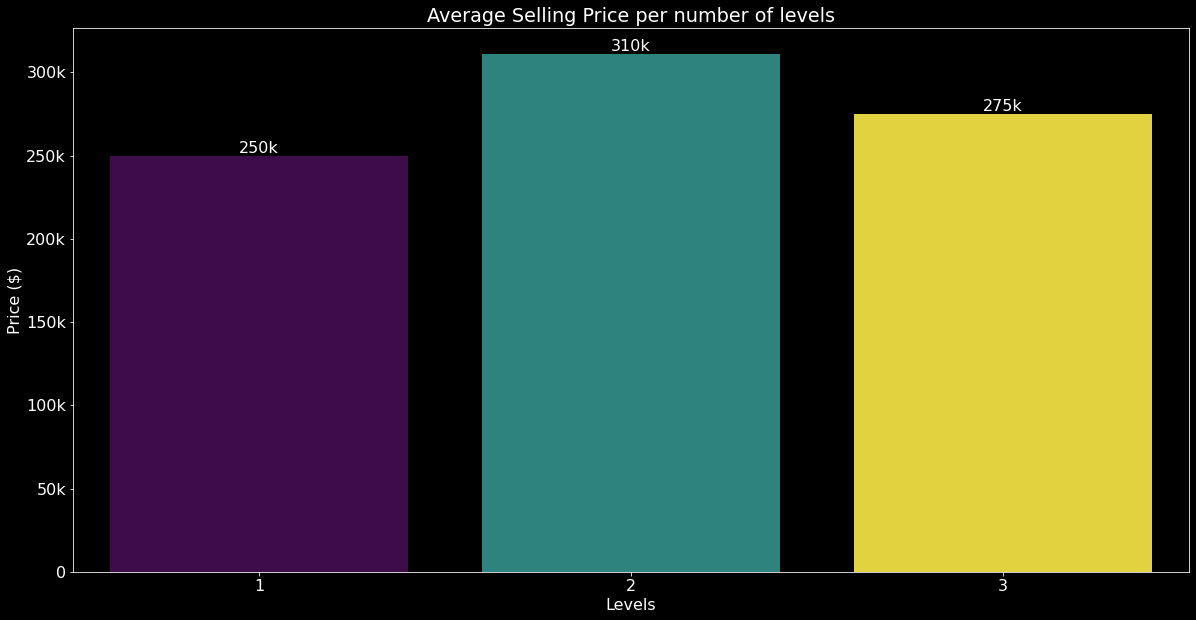

In [102]:
fig = plt.figure(figsize=[20, 10])
ax = sns.barplot(x="Levels", y="Price", data=levels_df, palette=color_palette("viridis", 3, 3, False))

ax.set_title("Average Selling Price per number of levels")
ax.set_ylabel("Price ($)")
ax.set_yticklabels(["0", "50k", "100k", "150k", "200k", "250k", "300k"])
ax.bar_label(ax.containers[0], labels=["250k", "310k", "275k"])
fig.add_axes(ax)

plt.savefig('./figures/visualization/levels-barplot.png', transparent=True, bbox_inches='tight')

C:\Users\simka\AppData\Local\Temp\ipykernel_23896\1650477366.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "0", "200k", "400k", "600k", "800k", "1M"])


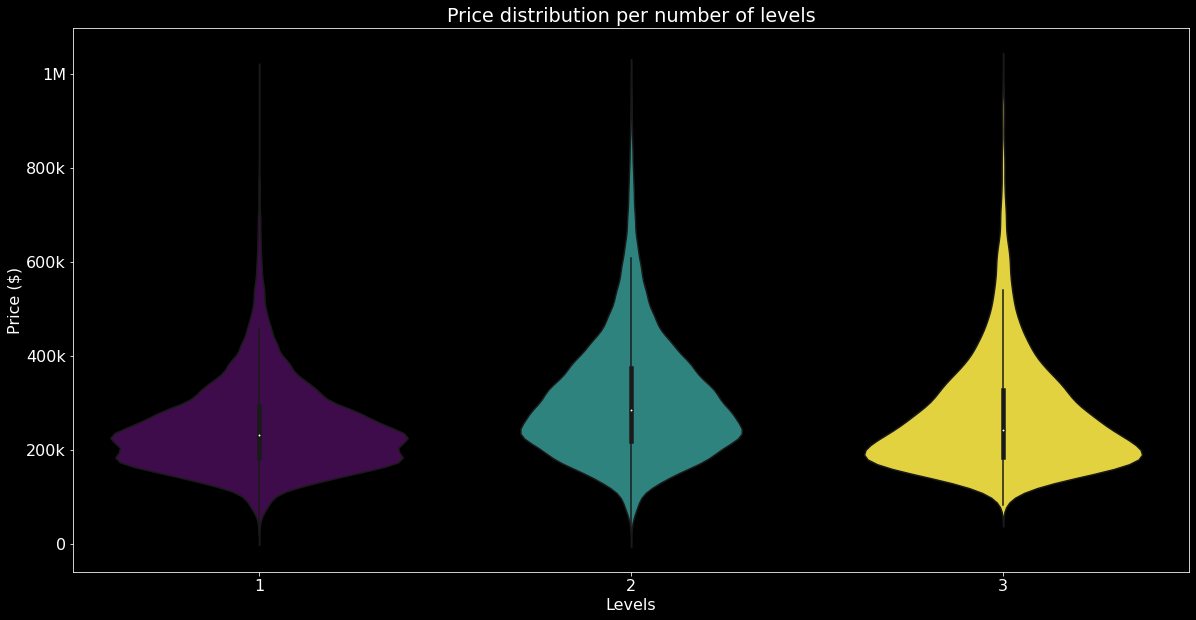

In [103]:
fig = plt.figure(figsize=[20, 10])
ax = sns.violinplot(data=listings_df, x="Levels", y="Price", palette=color_palette("viridis", 3, 3, False))

ax.set_title("Price distribution per number of levels")
ax.set_ylabel("Price ($)")
ax.set_yticklabels(["0", "0", "200k", "400k", "600k", "800k", "1M"])
fig.add_axes(ax)

plt.savefig('./figures/visualization/levels-violinplot.png', transparent=True, bbox_inches='tight')

### Listing Year

In [104]:
listing_year_df = group_column(listings_df, 'Listing Year')
listing_year_df = listing_year_df.sort_values(by=['Listing Year'], ascending=True)
listing_year_df

,Listing Year,Nb of listings,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Year of Construction,Age,Price
0,2001,1,1496,8260,3,2,1,1967,34,342000
1,2003,25,1006,6060,3,1,1,1984,18,152260
2,2004,155,905,6654,2,1,1,1987,16,139866
3,2005,625,1191,8353,3,1,1,1986,18,173744
4,2006,1141,1404,8721,3,1,1,1985,20,185139
5,2007,1536,1291,8649,3,1,1,1986,20,201841
6,2008,1830,1312,8622,3,1,1,1986,21,221940
7,2009,3056,1292,8661,3,1,1,1987,21,233480
8,2010,4802,1293,8961,3,1,1,1988,21,253398
9,2011,5374,1245,8475,3,1,1,1990,20,262367


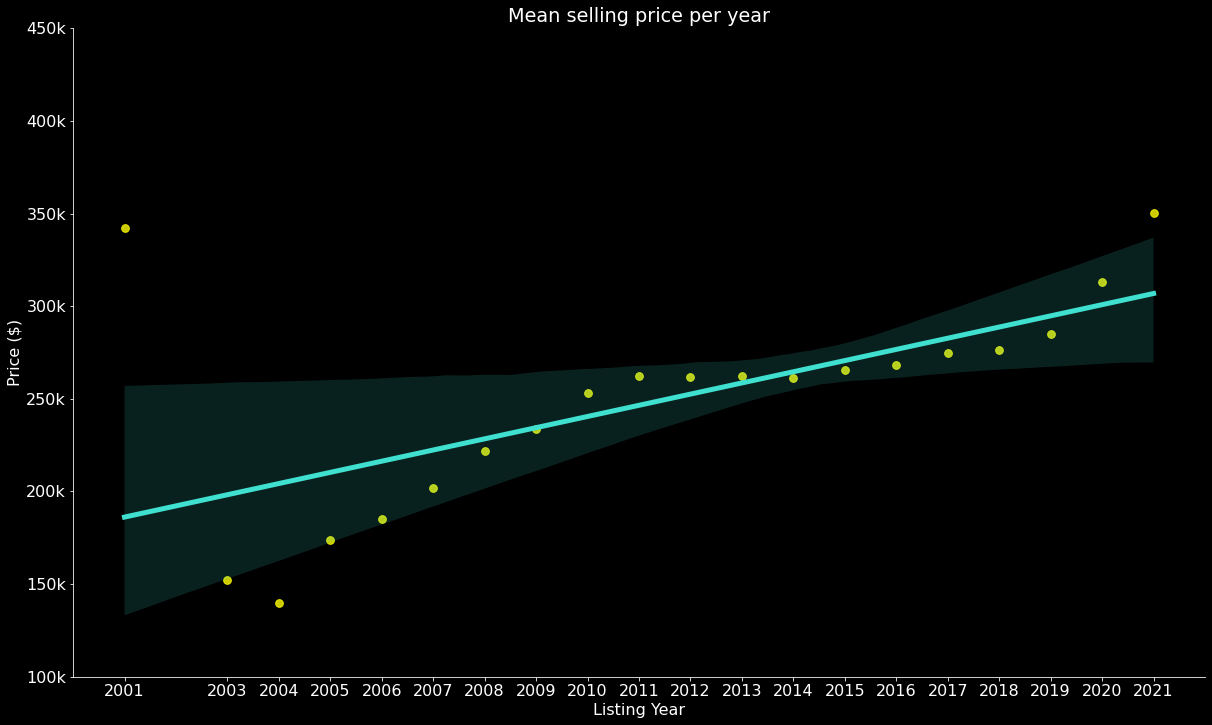

In [105]:
ax = sns.pairplot(data=listing_year_df, x_vars='Listing Year', y_vars='Price',
                  kind="reg", height=10, aspect=1.75, plot_kws=get_plot_kws('yellow', 'turquoise'))
ax.set(title="Mean selling price per year", xticks=listing_year_df["Listing Year"].unique(
), yticks=range(100000, 500000, 50000), ylabel="Price ($)", yticklabels=["100k", "150k", "200k", "250k", "300k", "350k", "400k", "450k"])

plt.savefig('./figures/visualization/listingyear-regplot.png', transparent=True, bbox_inches='tight')

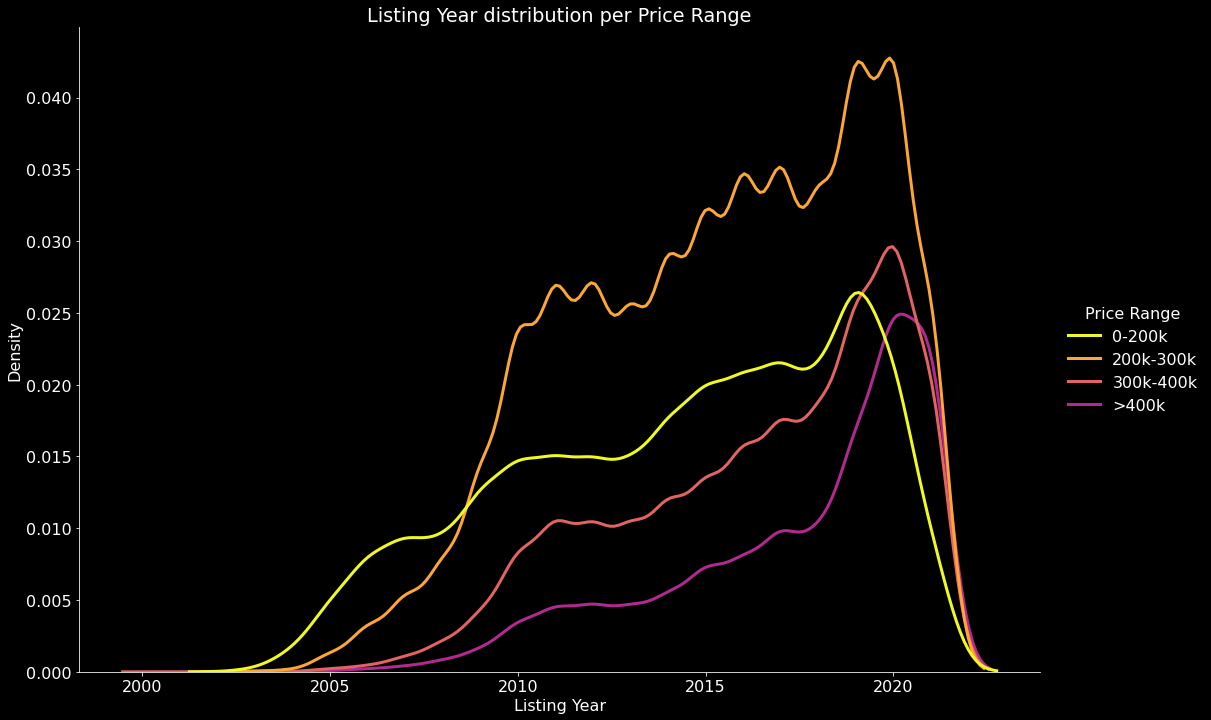

In [106]:
ranges = [200000, 300000, 400000]
df, labels = add_price_ranges(listings_df, ranges)

ax = sns.displot(df, x='Listing Year', hue='Price Range', hue_order=labels, kind="kde", common_norm=True,
            height=10, aspect=1.5, linewidth=3, palette=color_palette("plasma", 6, 4, True))
ax.set(title="Listing Year distribution per Price Range")

plt.savefig('./figures/visualization/listingyear-displot.png', transparent=True, bbox_inches='tight')

c:\Users\simka\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\axisgrid.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


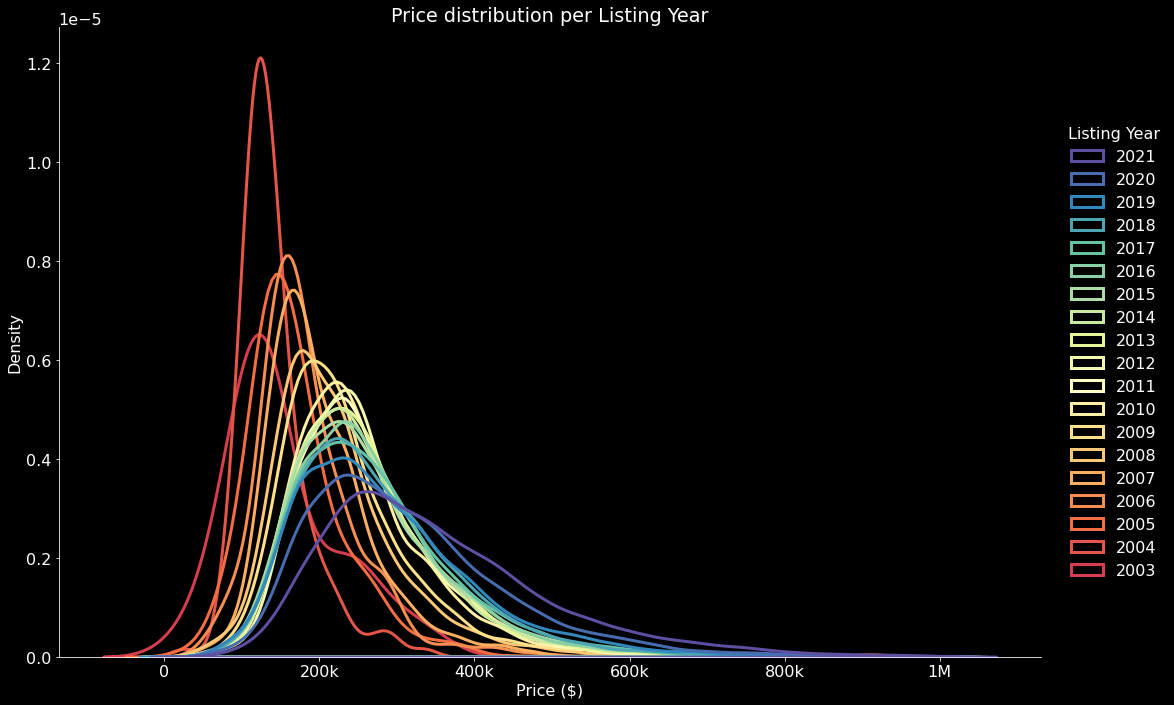

In [107]:
ax = sns.displot(listings_df, x='Price', hue='Listing Year', hue_order=range(2021, 2002, -1), kind="kde", fill=True, common_norm=False,
            height=10, aspect=1.5, alpha=.0, linewidth=3, palette=color_palette("Spectral_r", 21, len(range(2021, 2002, -1)), False))
ax.set(title="Price distribution per Listing Year", xlabel="Price ($)", xticklabels=["0", "0", "200k", "400k", "600k", "800k", "1M"])

plt.savefig('./figures/visualization/listingyear-pricedisplot.png', transparent=True, bbox_inches='tight')

### Age

In [108]:
age_df = group_column(listings_df, 'Age')
age_df = age_df.sort_values(by=['Age'], ascending=True)
age_df

,Age,Nb of listings,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Year,Year of Construction,Price
0,0,877,1265,9189,2,1,1,2012,2012,263797
1,1,1948,1341,9835,2,1,1,2013,2012,289648
2,2,2817,1333,9417,2,1,1,2013,2011,286139
3,3,3324,1299,9091,2,1,1,2014,2011,279510
4,4,3580,1283,9011,2,1,1,2014,2010,280010
...,...,...,...,...,...,...,...,...,...,...
162,162,6,1680,16751,3,1,1,2017,1855,213125
163,163,2,2476,13500,3,1,2,2014,1851,372500
164,165,1,1265,9291,3,1,2,2017,1852,189900
165,167,4,1885,10333,4,1,2,2018,1851,284000


c:\Users\simka\Documents\GitHub\quebec-real-estate\venv\lib\site-packages\seaborn\axisgrid.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set(**kwargs)


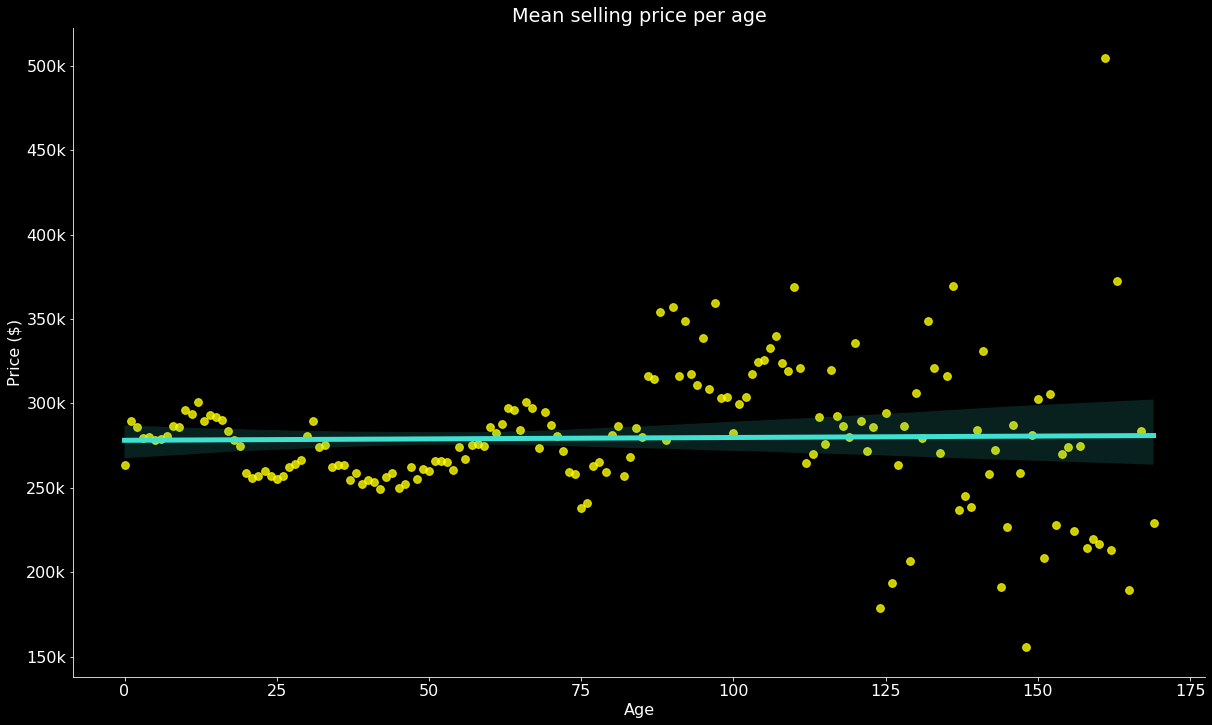

In [109]:
ax = sns.pairplot(data=age_df, x_vars='Age', y_vars='Price',
                  kind="reg", height=10, aspect=1.75, plot_kws=get_plot_kws('yellow', 'turquoise'))

ax.set(title="Mean selling price per age", ylabel="Price ($)", yticklabels=["100k", "150k", "200k", "250k", "300k", "350k", "400k", "450k", "500k", "550k"])

plt.savefig('./figures/visualization/age-regplot.png', transparent=True, bbox_inches='tight')

### Location

Read Data

In [ ]:
locations_df = pd.read_csv('../data/processed/visualization/locations.csv')
locations_df.sample(5)

,Location,Bounding Territory,Bounding Type,Population,GeoPy Index,Nb of listings,Subtype,Living Area,Lot Dimensions,Bedrooms,Bathrooms,Levels,Listing Year,Year of Construction,Age,Price,Price Range
10,Charlevoix,"[Charlevoix,Charlevoix-Est]",Regional County Municipality (RCM),30000,0,227,Bungalow,1360,13485,3,1,1,2015,1987,28,222499,210k-250k
7,La Haute-Saint-Charles,La Haute-Saint-Charles,Québec City Borough,85000,0,2609,Bungalow,1139,6456,3,1,1,2014,1994,19,249697,210k-250k
51,Laval-des-Rapides,"[Laval-des-Rapides,Pont-Viau Laval]",Laval Borough,50000,0,325,Condominium,1107,6784,2,1,1,2015,1982,33,301804,300k-320k
36,Les Maskoutains & Acton,"[Les Maskoutains,Acton]",Regional County Municipality (RCM),105000,0,873,Bungalow,1278,10246,3,1,1,2016,1988,27,250553,250k-275k
53,Ahuntsic-Cartierville,Ahuntsic-Cartierville,Montréal Borough,135000,0,604,Condominium,1140,6921,2,1,1,2015,1979,35,373895,350k-400k


Chlorpleth Map

In [ ]:
geolocator = Nominatim(user_agent='housing-qc-viz')
qc_choro_map = folium.Map(location=[47.0, -70.5], zoom_start=7)
folium.TileLayer('cartodbdark_matter').add_to(qc_choro_map)  # Sets Tile Theme to (Dark Theme)

In [ ]:
den_colormap = cm.linear.RdYlGn_11.colors
den_colormap.reverse()
colormap = cm.LinearColormap(colors=['darkgreen', 'green', 'limegreen', 'greenyellow', 'yellow', 'gold', 'orange', 'darkorange', 'red', 'darkred'], index=[
                             180000, 200000, 220000, 250000, 300000, 325000, 350000, 400000, 500000, 600000], vmin=180000, vmax=600000, max_labels=4)
                             
colormap.caption = 'Price'
colormap.add_to(qc_choro_map)


In [ ]:
for i, r in tqdm(locations_df.iterrows(), desc="Adding Geometries", total=locations_df.shape[0]):
    price = str(r["Price"])
    popup = r["Location"] + " - " + price[:3] + "k "+ "$"
    try:
        add_geometry(qc_choro_map, geolocator, r["Bounding Territory"], popup, colormap(r["Price"]), r["GeoPy Index"])
    except:
        print("Unable to calculate geometry for: " + r["Bounding Territory"])

Adding Geometries: 100%|██████████| 111/111 [01:13<00:00,  1.51it/s]


In [ ]:
qc_choro_map.save("figures/visualization/choropleth_map.html")

In [ ]:
qc_choro_map